# Roberta model construction with Gab data

2020/11/16

Student: Xuanyu Su                                                                 
Supervisor: Isar Nejadgholi

In this file, we built an RoBERTa model by using Gab data to compare the distance among different databases, and use the final result to compare with the graph we conducted in week 11.

in this version we remove the fine-tuning module(use part of test data pretrain on linear layers)

In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [2]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [54]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'Text' : ('Text', text_field), 'Hate' : ('Hate', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path="Data/final_GAB.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='Hate')

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.Text), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [4]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [5]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x1 = self.d1(x)
        x2 = self.l1(x1)
        x3 = self.bn1(x2)
        x4 = torch.nn.Tanh()(x3)
        x5 = self.d2(x4)
        x6 = self.l2(x5)
        
        return x6

In [9]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
        
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            print('batch_no [{}/{}]:'.format(count, int(len(train_iter)/BATCH_SIZE)),'training_loss:',loss)
            count+=1
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [10]:
# Training Function
output_path = 'Model_roberta'
def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)

            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            print('batch_no [{}/{}]:'.format(count, int(len(train_iter)/BATCH_SIZE)),'training_loss:',loss)
            count+=1
            loss.backward()
            
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)

                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)

                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [11]:
# Main training loop
NUM_EPOCHS = 2
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.3)
model = model.to(device)

print("======================= Start pretraining ==============================")



optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)
pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 3
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

======================= Start pretraining ==============================
batch_no [0/302]: training_loss: tensor(1.0268, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1/302]: training_loss: tensor(0.7395, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2/302]: training_loss: tensor(0.5533, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [3/302]: training_loss: tensor(0.4738, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [4/302]: training_loss: tensor(0.5393, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [5/302]: training_loss: tensor(0.4750, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [6/302]: training_loss: tensor(0.4942, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [7/302]: training_loss: tensor(0.5939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [8/302]: training_loss: tensor(0.4486, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [9/302]: training_loss: tensor(0.4998, device='cuda:0', grad_fn=<NllLossBackward>)
batch_n

batch_no [90/302]: training_loss: tensor(0.3716, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [91/302]: training_loss: tensor(0.4498, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [92/302]: training_loss: tensor(0.3218, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [93/302]: training_loss: tensor(0.5258, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [94/302]: training_loss: tensor(1.1513, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [95/302]: training_loss: tensor(1.0559, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [96/302]: training_loss: tensor(0.9832, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [97/302]: training_loss: tensor(0.8723, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [98/302]: training_loss: tensor(0.3788, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [99/302]: training_loss: tensor(0.3847, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [100/302]: training_loss: tensor(0.4124, device='cuda:0', gra

batch_no [180/302]: training_loss: tensor(0.1938, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [181/302]: training_loss: tensor(0.2841, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [182/302]: training_loss: tensor(0.1980, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [183/302]: training_loss: tensor(0.2656, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [184/302]: training_loss: tensor(0.2198, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [185/302]: training_loss: tensor(0.1943, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [186/302]: training_loss: tensor(0.2388, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [187/302]: training_loss: tensor(0.2473, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [188/302]: training_loss: tensor(0.2948, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [189/302]: training_loss: tensor(0.2735, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [190/302]: training_loss: tensor(0.1939, device='cu

batch_no [358/302]: training_loss: tensor(0.0986, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [359/302]: training_loss: tensor(0.0929, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [360/302]: training_loss: tensor(0.1182, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [361/302]: training_loss: tensor(0.0817, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [362/302]: training_loss: tensor(0.1018, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [363/302]: training_loss: tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [364/302]: training_loss: tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [365/302]: training_loss: tensor(0.0746, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [366/302]: training_loss: tensor(0.0936, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [367/302]: training_loss: tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [368/302]: training_loss: tensor(2.0216, device='cu

batch_no [535/302]: training_loss: tensor(0.1164, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [536/302]: training_loss: tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [537/302]: training_loss: tensor(0.0848, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [538/302]: training_loss: tensor(0.1116, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [539/302]: training_loss: tensor(0.0987, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [540/302]: training_loss: tensor(0.0999, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [541/302]: training_loss: tensor(0.0892, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [542/302]: training_loss: tensor(0.0774, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [543/302]: training_loss: tensor(0.0975, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [544/302]: training_loss: tensor(0.0783, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [545/302]: training_loss: tensor(0.0777, device='cu

batch_no [626/302]: training_loss: tensor(0.0800, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [627/302]: training_loss: tensor(0.0824, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [628/302]: training_loss: tensor(0.0639, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [629/302]: training_loss: tensor(0.0800, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [630/302]: training_loss: tensor(0.0911, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [631/302]: training_loss: tensor(0.0858, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [632/302]: training_loss: tensor(0.0822, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [633/302]: training_loss: tensor(0.0858, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [634/302]: training_loss: tensor(0.0765, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [635/302]: training_loss: tensor(0.0746, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [636/302]: training_loss: tensor(0.0655, device='cu

batch_no [716/302]: training_loss: tensor(0.0563, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [717/302]: training_loss: tensor(0.0699, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [718/302]: training_loss: tensor(0.0896, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [719/302]: training_loss: tensor(0.0640, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [720/302]: training_loss: tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [721/302]: training_loss: tensor(0.0538, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [722/302]: training_loss: tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [723/302]: training_loss: tensor(0.0641, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [724/302]: training_loss: tensor(0.0609, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [725/302]: training_loss: tensor(0.0717, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [726/302]: training_loss: tensor(0.0524, device='cu

batch_no [806/302]: training_loss: tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [807/302]: training_loss: tensor(0.0681, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [808/302]: training_loss: tensor(0.0659, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [809/302]: training_loss: tensor(0.0839, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [810/302]: training_loss: tensor(0.0776, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [811/302]: training_loss: tensor(0.0807, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [812/302]: training_loss: tensor(0.0675, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [813/302]: training_loss: tensor(0.0702, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [814/302]: training_loss: tensor(0.0845, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [815/302]: training_loss: tensor(0.0661, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [816/302]: training_loss: tensor(0.0719, device='cu

batch_no [897/302]: training_loss: tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [898/302]: training_loss: tensor(0.0626, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [899/302]: training_loss: tensor(0.0597, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [900/302]: training_loss: tensor(0.0604, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [901/302]: training_loss: tensor(0.0638, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [902/302]: training_loss: tensor(0.0481, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [903/302]: training_loss: tensor(0.0464, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [904/302]: training_loss: tensor(0.3579, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [905/302]: training_loss: tensor(2.7521, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [906/302]: training_loss: tensor(2.8595, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [907/302]: training_loss: tensor(3.0381, device='cu

batch_no [985/302]: training_loss: tensor(2.8819, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [986/302]: training_loss: tensor(2.8226, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [987/302]: training_loss: tensor(2.8604, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [988/302]: training_loss: tensor(2.7653, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [989/302]: training_loss: tensor(2.8104, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [990/302]: training_loss: tensor(2.6358, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [991/302]: training_loss: tensor(2.8285, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [992/302]: training_loss: tensor(0.9492, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [993/302]: training_loss: tensor(0.0753, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [994/302]: training_loss: tensor(0.1012, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [995/302]: training_loss: tensor(0.1218, device='cu

batch_no [1074/302]: training_loss: tensor(0.1039, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1075/302]: training_loss: tensor(0.0882, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1076/302]: training_loss: tensor(0.0965, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1077/302]: training_loss: tensor(0.1352, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1078/302]: training_loss: tensor(0.1247, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1079/302]: training_loss: tensor(0.0857, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1080/302]: training_loss: tensor(0.1092, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1081/302]: training_loss: tensor(0.1163, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1082/302]: training_loss: tensor(0.1181, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1083/302]: training_loss: tensor(0.1333, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1084/302]: training_loss: tensor(0.1034,

batch_no [1162/302]: training_loss: tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1163/302]: training_loss: tensor(0.0951, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1164/302]: training_loss: tensor(0.0810, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1165/302]: training_loss: tensor(0.0767, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1166/302]: training_loss: tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1167/302]: training_loss: tensor(0.1053, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1168/302]: training_loss: tensor(0.0685, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1169/302]: training_loss: tensor(0.0917, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1170/302]: training_loss: tensor(0.0909, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1171/302]: training_loss: tensor(0.0806, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1172/302]: training_loss: tensor(0.0923,

batch_no [1338/302]: training_loss: tensor(0.1019, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1339/302]: training_loss: tensor(0.1096, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1340/302]: training_loss: tensor(0.1454, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1341/302]: training_loss: tensor(0.1134, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1342/302]: training_loss: tensor(0.0971, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1343/302]: training_loss: tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1344/302]: training_loss: tensor(0.0880, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1345/302]: training_loss: tensor(0.0751, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1346/302]: training_loss: tensor(0.0818, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1347/302]: training_loss: tensor(0.0942, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1348/302]: training_loss: tensor(0.0902,

batch_no [1428/302]: training_loss: tensor(0.0981, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1429/302]: training_loss: tensor(0.1006, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1430/302]: training_loss: tensor(0.1030, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1431/302]: training_loss: tensor(0.1015, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1432/302]: training_loss: tensor(0.0874, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1433/302]: training_loss: tensor(0.1047, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1434/302]: training_loss: tensor(0.0898, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1435/302]: training_loss: tensor(0.0876, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1436/302]: training_loss: tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1437/302]: training_loss: tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1438/302]: training_loss: tensor(0.1034,

batch_no [1518/302]: training_loss: tensor(0.0846, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1519/302]: training_loss: tensor(0.0898, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1520/302]: training_loss: tensor(0.0703, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1521/302]: training_loss: tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1522/302]: training_loss: tensor(0.0912, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1523/302]: training_loss: tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1524/302]: training_loss: tensor(0.0858, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1525/302]: training_loss: tensor(0.0728, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1526/302]: training_loss: tensor(0.0854, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1527/302]: training_loss: tensor(0.0895, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1528/302]: training_loss: tensor(0.0897,

batch_no [1691/302]: training_loss: tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1692/302]: training_loss: tensor(0.0670, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1693/302]: training_loss: tensor(0.0674, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1694/302]: training_loss: tensor(0.0664, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1695/302]: training_loss: tensor(0.0649, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1696/302]: training_loss: tensor(0.1014, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1697/302]: training_loss: tensor(0.7175, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1698/302]: training_loss: tensor(2.6921, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1699/302]: training_loss: tensor(2.8063, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1700/302]: training_loss: tensor(0.8252, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1701/302]: training_loss: tensor(0.0658,

batch_no [1778/302]: training_loss: tensor(0.0980, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1779/302]: training_loss: tensor(0.0973, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1780/302]: training_loss: tensor(0.0806, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1781/302]: training_loss: tensor(0.0965, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1782/302]: training_loss: tensor(0.0790, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1783/302]: training_loss: tensor(0.0735, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1784/302]: training_loss: tensor(0.0763, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1785/302]: training_loss: tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1786/302]: training_loss: tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1787/302]: training_loss: tensor(0.0713, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1788/302]: training_loss: tensor(0.0873,

batch_no [1867/302]: training_loss: tensor(2.7024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1868/302]: training_loss: tensor(1.3844, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1869/302]: training_loss: tensor(0.0650, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1870/302]: training_loss: tensor(0.0869, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1871/302]: training_loss: tensor(0.0811, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1872/302]: training_loss: tensor(0.0682, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1873/302]: training_loss: tensor(0.0639, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1874/302]: training_loss: tensor(0.0798, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1875/302]: training_loss: tensor(0.0918, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1876/302]: training_loss: tensor(0.0624, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1877/302]: training_loss: tensor(0.0850,

batch_no [2040/302]: training_loss: tensor(0.0718, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2041/302]: training_loss: tensor(0.0784, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2042/302]: training_loss: tensor(0.1007, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2043/302]: training_loss: tensor(0.0643, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2044/302]: training_loss: tensor(0.0846, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2045/302]: training_loss: tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2046/302]: training_loss: tensor(0.0850, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2047/302]: training_loss: tensor(0.0850, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2048/302]: training_loss: tensor(0.0720, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2049/302]: training_loss: tensor(0.1013, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2050/302]: training_loss: tensor(0.0767,

batch_no [2127/302]: training_loss: tensor(0.0872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2128/302]: training_loss: tensor(0.0641, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2129/302]: training_loss: tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2130/302]: training_loss: tensor(0.7028, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2131/302]: training_loss: tensor(1.8045, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2132/302]: training_loss: tensor(0.0770, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2133/302]: training_loss: tensor(0.0806, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2134/302]: training_loss: tensor(0.0656, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2135/302]: training_loss: tensor(0.1062, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2136/302]: training_loss: tensor(0.1007, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2137/302]: training_loss: tensor(0.0628,

batch_no [2303/302]: training_loss: tensor(0.0859, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2304/302]: training_loss: tensor(0.0736, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2305/302]: training_loss: tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2306/302]: training_loss: tensor(0.0973, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2307/302]: training_loss: tensor(0.0969, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2308/302]: training_loss: tensor(0.1014, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2309/302]: training_loss: tensor(0.1034, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2310/302]: training_loss: tensor(0.3773, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2311/302]: training_loss: tensor(2.2049, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2312/302]: training_loss: tensor(0.0954, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2313/302]: training_loss: tensor(0.0900,

batch_no [2391/302]: training_loss: tensor(0.0907, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2392/302]: training_loss: tensor(0.0865, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2393/302]: training_loss: tensor(0.5490, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2394/302]: training_loss: tensor(0.1009, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2395/302]: training_loss: tensor(0.0910, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2396/302]: training_loss: tensor(0.3443, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2397/302]: training_loss: tensor(0.0973, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2398/302]: training_loss: tensor(0.0925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2399/302]: training_loss: tensor(0.0926, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2400/302]: training_loss: tensor(1.3075, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2401/302]: training_loss: tensor(0.0836,

batch_no [59/302]: training_loss: tensor(0.1121, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [60/302]: training_loss: tensor(0.0951, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [61/302]: training_loss: tensor(0.1037, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [62/302]: training_loss: tensor(0.1047, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [63/302]: training_loss: tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [64/302]: training_loss: tensor(0.0995, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [65/302]: training_loss: tensor(0.6639, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [66/302]: training_loss: tensor(2.5363, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [67/302]: training_loss: tensor(1.6714, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [68/302]: training_loss: tensor(0.0763, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [69/302]: training_loss: tensor(0.1032, device='cuda:0', grad

batch_no [149/302]: training_loss: tensor(0.1176, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [150/302]: training_loss: tensor(0.1254, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [151/302]: training_loss: tensor(0.1186, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [152/302]: training_loss: tensor(0.1252, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [153/302]: training_loss: tensor(0.1117, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [154/302]: training_loss: tensor(0.1110, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [155/302]: training_loss: tensor(0.1063, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [156/302]: training_loss: tensor(0.0932, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [157/302]: training_loss: tensor(0.0962, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [158/302]: training_loss: tensor(0.0983, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [159/302]: training_loss: tensor(0.1007, device='cu

batch_no [238/302]: training_loss: tensor(0.0746, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [239/302]: training_loss: tensor(0.0953, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [240/302]: training_loss: tensor(0.0817, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [241/302]: training_loss: tensor(0.0913, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [242/302]: training_loss: tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [243/302]: training_loss: tensor(0.0883, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [244/302]: training_loss: tensor(0.0811, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [245/302]: training_loss: tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [246/302]: training_loss: tensor(0.0690, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [247/302]: training_loss: tensor(0.0789, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [248/302]: training_loss: tensor(0.0678, device='cu

batch_no [328/302]: training_loss: tensor(0.0744, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [329/302]: training_loss: tensor(0.0825, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [330/302]: training_loss: tensor(0.0881, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [331/302]: training_loss: tensor(0.0661, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [332/302]: training_loss: tensor(0.0830, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [333/302]: training_loss: tensor(0.0614, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [334/302]: training_loss: tensor(0.0824, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [335/302]: training_loss: tensor(0.0951, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [336/302]: training_loss: tensor(0.0764, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [337/302]: training_loss: tensor(0.0802, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [338/302]: training_loss: tensor(0.0878, device='cu

batch_no [505/302]: training_loss: tensor(0.1094, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [506/302]: training_loss: tensor(0.1119, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [507/302]: training_loss: tensor(0.0989, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [508/302]: training_loss: tensor(0.0989, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [509/302]: training_loss: tensor(0.1048, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [510/302]: training_loss: tensor(0.1002, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [511/302]: training_loss: tensor(0.1005, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [512/302]: training_loss: tensor(0.0930, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [513/302]: training_loss: tensor(0.1040, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [514/302]: training_loss: tensor(0.0843, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [515/302]: training_loss: tensor(0.0895, device='cu

batch_no [595/302]: training_loss: tensor(0.1077, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [596/302]: training_loss: tensor(0.1222, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [597/302]: training_loss: tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [598/302]: training_loss: tensor(0.1139, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [599/302]: training_loss: tensor(0.1219, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [600/302]: training_loss: tensor(0.1109, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [601/302]: training_loss: tensor(0.0971, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [602/302]: training_loss: tensor(0.1186, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [603/302]: training_loss: tensor(0.1106, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [604/302]: training_loss: tensor(0.0916, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [605/302]: training_loss: tensor(0.0933, device='cu

batch_no [772/302]: training_loss: tensor(0.1169, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [773/302]: training_loss: tensor(0.1180, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [774/302]: training_loss: tensor(0.0907, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [775/302]: training_loss: tensor(0.1088, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [776/302]: training_loss: tensor(0.1305, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [777/302]: training_loss: tensor(0.1073, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [778/302]: training_loss: tensor(0.0884, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [779/302]: training_loss: tensor(0.0905, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [780/302]: training_loss: tensor(0.1164, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [781/302]: training_loss: tensor(0.0935, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [782/302]: training_loss: tensor(0.0911, device='cu

batch_no [862/302]: training_loss: tensor(0.0932, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [863/302]: training_loss: tensor(0.1035, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [864/302]: training_loss: tensor(0.0958, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [865/302]: training_loss: tensor(0.0918, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [866/302]: training_loss: tensor(0.1039, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [867/302]: training_loss: tensor(0.0902, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [868/302]: training_loss: tensor(0.1074, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [869/302]: training_loss: tensor(0.0849, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [870/302]: training_loss: tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [871/302]: training_loss: tensor(0.0822, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [872/302]: training_loss: tensor(0.1175, device='cu

batch_no [951/302]: training_loss: tensor(0.0858, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [952/302]: training_loss: tensor(0.0980, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [953/302]: training_loss: tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [954/302]: training_loss: tensor(0.0848, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [955/302]: training_loss: tensor(0.0962, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [956/302]: training_loss: tensor(0.0964, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [957/302]: training_loss: tensor(0.1048, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [958/302]: training_loss: tensor(0.0899, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [959/302]: training_loss: tensor(0.0815, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [960/302]: training_loss: tensor(0.0926, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [961/302]: training_loss: tensor(0.0981, device='cu

batch_no [1040/302]: training_loss: tensor(0.0899, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1041/302]: training_loss: tensor(0.0876, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1042/302]: training_loss: tensor(0.0941, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1043/302]: training_loss: tensor(0.0820, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1044/302]: training_loss: tensor(0.1065, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1045/302]: training_loss: tensor(0.1044, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1046/302]: training_loss: tensor(0.0826, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1047/302]: training_loss: tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1048/302]: training_loss: tensor(0.0834, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1049/302]: training_loss: tensor(0.1075, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1050/302]: training_loss: tensor(0.0971,

batch_no [1128/302]: training_loss: tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1129/302]: training_loss: tensor(0.0876, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1130/302]: training_loss: tensor(0.0758, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1131/302]: training_loss: tensor(2.5959, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1132/302]: training_loss: tensor(2.3618, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1133/302]: training_loss: tensor(2.4700, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1134/302]: training_loss: tensor(2.4976, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1135/302]: training_loss: tensor(1.4757, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1136/302]: training_loss: tensor(0.0947, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1137/302]: training_loss: tensor(0.0776, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1138/302]: training_loss: tensor(0.0818,

batch_no [1215/302]: training_loss: tensor(0.1027, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1216/302]: training_loss: tensor(0.0817, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1217/302]: training_loss: tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1218/302]: training_loss: tensor(0.0893, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1219/302]: training_loss: tensor(0.0955, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1220/302]: training_loss: tensor(0.0874, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1221/302]: training_loss: tensor(0.1102, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1222/302]: training_loss: tensor(0.0959, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1223/302]: training_loss: tensor(0.1146, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1224/302]: training_loss: tensor(0.0727, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1225/302]: training_loss: tensor(0.0893,

batch_no [1389/302]: training_loss: tensor(0.1018, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1390/302]: training_loss: tensor(0.0895, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1391/302]: training_loss: tensor(0.0943, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1392/302]: training_loss: tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1393/302]: training_loss: tensor(0.1104, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1394/302]: training_loss: tensor(0.1046, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1395/302]: training_loss: tensor(0.0872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1396/302]: training_loss: tensor(0.0898, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1397/302]: training_loss: tensor(0.0745, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1398/302]: training_loss: tensor(0.0868, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1399/302]: training_loss: tensor(0.0946,

batch_no [1562/302]: training_loss: tensor(0.0891, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1563/302]: training_loss: tensor(0.1018, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1564/302]: training_loss: tensor(0.0880, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1565/302]: training_loss: tensor(0.0813, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1566/302]: training_loss: tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1567/302]: training_loss: tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1568/302]: training_loss: tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1569/302]: training_loss: tensor(0.0737, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1570/302]: training_loss: tensor(0.0897, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1571/302]: training_loss: tensor(0.0756, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1572/302]: training_loss: tensor(0.0866,

batch_no [1649/302]: training_loss: tensor(0.0638, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1650/302]: training_loss: tensor(0.0688, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1651/302]: training_loss: tensor(0.0979, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1652/302]: training_loss: tensor(0.0947, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1653/302]: training_loss: tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1654/302]: training_loss: tensor(0.0768, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1655/302]: training_loss: tensor(0.1012, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1656/302]: training_loss: tensor(0.0947, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1657/302]: training_loss: tensor(0.1093, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1658/302]: training_loss: tensor(0.0840, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1659/302]: training_loss: tensor(0.0749,

batch_no [1821/302]: training_loss: tensor(0.0866, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1822/302]: training_loss: tensor(0.0815, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1823/302]: training_loss: tensor(0.0870, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1824/302]: training_loss: tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1825/302]: training_loss: tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1826/302]: training_loss: tensor(0.0920, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1827/302]: training_loss: tensor(0.0957, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1828/302]: training_loss: tensor(0.0878, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1829/302]: training_loss: tensor(0.0762, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1830/302]: training_loss: tensor(0.0808, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1831/302]: training_loss: tensor(0.0796,

batch_no [1996/302]: training_loss: tensor(2.6353, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1997/302]: training_loss: tensor(2.6466, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1998/302]: training_loss: tensor(0.3917, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1999/302]: training_loss: tensor(0.0983, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2000/302]: training_loss: tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2001/302]: training_loss: tensor(0.0928, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2002/302]: training_loss: tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2003/302]: training_loss: tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2004/302]: training_loss: tensor(0.0857, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2005/302]: training_loss: tensor(0.0720, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2006/302]: training_loss: tensor(0.0951,

batch_no [2085/302]: training_loss: tensor(0.0965, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2086/302]: training_loss: tensor(0.0737, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2087/302]: training_loss: tensor(1.2578, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2088/302]: training_loss: tensor(1.7051, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2089/302]: training_loss: tensor(0.0859, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2090/302]: training_loss: tensor(0.0813, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2091/302]: training_loss: tensor(0.0866, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2092/302]: training_loss: tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2093/302]: training_loss: tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2094/302]: training_loss: tensor(0.0789, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2095/302]: training_loss: tensor(0.0825,

batch_no [2172/302]: training_loss: tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2173/302]: training_loss: tensor(0.0723, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2174/302]: training_loss: tensor(1.6011, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2175/302]: training_loss: tensor(1.8182, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2176/302]: training_loss: tensor(0.0693, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2177/302]: training_loss: tensor(0.0803, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2178/302]: training_loss: tensor(0.1084, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2179/302]: training_loss: tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2180/302]: training_loss: tensor(0.0950, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2181/302]: training_loss: tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2182/302]: training_loss: tensor(0.0905,

batch_no [2261/302]: training_loss: tensor(0.0767, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2262/302]: training_loss: tensor(1.6969, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2263/302]: training_loss: tensor(0.0981, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2264/302]: training_loss: tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2265/302]: training_loss: tensor(0.0687, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2266/302]: training_loss: tensor(0.0926, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2267/302]: training_loss: tensor(0.0774, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2268/302]: training_loss: tensor(0.0715, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2269/302]: training_loss: tensor(0.0755, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2270/302]: training_loss: tensor(0.0789, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2271/302]: training_loss: tensor(0.4181,

batch_no [11/302]: training_loss: tensor(0.0800, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [12/302]: training_loss: tensor(0.0886, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [13/302]: training_loss: tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [14/302]: training_loss: tensor(0.0735, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [15/302]: training_loss: tensor(0.0892, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [16/302]: training_loss: tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [17/302]: training_loss: tensor(0.0879, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [18/302]: training_loss: tensor(0.0897, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [19/302]: training_loss: tensor(0.0966, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [20/302]: training_loss: tensor(0.0778, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [21/302]: training_loss: tensor(0.0912, device='cuda:0', grad

batch_no [100/302]: training_loss: tensor(0.1027, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [101/302]: training_loss: tensor(0.0897, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [102/302]: training_loss: tensor(0.0807, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [103/302]: training_loss: tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [104/302]: training_loss: tensor(0.0956, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [105/302]: training_loss: tensor(0.0871, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [106/302]: training_loss: tensor(0.1148, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [107/302]: training_loss: tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [108/302]: training_loss: tensor(0.0926, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [109/302]: training_loss: tensor(0.0826, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [110/302]: training_loss: tensor(0.0848, device='cu

batch_no [188/302]: training_loss: tensor(0.0632, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [189/302]: training_loss: tensor(0.0727, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [190/302]: training_loss: tensor(0.1072, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [191/302]: training_loss: tensor(0.0781, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [192/302]: training_loss: tensor(0.0821, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [193/302]: training_loss: tensor(0.0785, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [194/302]: training_loss: tensor(0.0680, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [195/302]: training_loss: tensor(0.0902, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [196/302]: training_loss: tensor(0.0903, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [197/302]: training_loss: tensor(2.7691, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [198/302]: training_loss: tensor(2.5152, device='cu

batch_no [276/302]: training_loss: tensor(1.2923, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [277/302]: training_loss: tensor(2.4191, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [278/302]: training_loss: tensor(2.2621, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [279/302]: training_loss: tensor(2.4937, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [280/302]: training_loss: tensor(2.5760, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [281/302]: training_loss: tensor(2.5259, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [282/302]: training_loss: tensor(2.2338, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [283/302]: training_loss: tensor(1.9996, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [284/302]: training_loss: tensor(0.0803, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [285/302]: training_loss: tensor(0.0743, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [286/302]: training_loss: tensor(0.0870, device='cu

batch_no [364/302]: training_loss: tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [365/302]: training_loss: tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [366/302]: training_loss: tensor(0.0951, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [367/302]: training_loss: tensor(0.0830, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [368/302]: training_loss: tensor(2.1679, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [369/302]: training_loss: tensor(2.6833, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [370/302]: training_loss: tensor(2.4991, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [371/302]: training_loss: tensor(2.4237, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [372/302]: training_loss: tensor(2.5999, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [373/302]: training_loss: tensor(2.5219, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [374/302]: training_loss: tensor(2.6012, device='cu

batch_no [452/302]: training_loss: tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [453/302]: training_loss: tensor(0.0694, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [454/302]: training_loss: tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [455/302]: training_loss: tensor(0.1017, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [456/302]: training_loss: tensor(0.0933, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [457/302]: training_loss: tensor(0.0903, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [458/302]: training_loss: tensor(0.0989, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [459/302]: training_loss: tensor(0.0718, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [460/302]: training_loss: tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [461/302]: training_loss: tensor(0.3881, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [462/302]: training_loss: tensor(2.8206, device='cu

batch_no [627/302]: training_loss: tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [628/302]: training_loss: tensor(0.0741, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [629/302]: training_loss: tensor(0.0780, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [630/302]: training_loss: tensor(0.0869, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [631/302]: training_loss: tensor(0.0747, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [632/302]: training_loss: tensor(0.0900, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [633/302]: training_loss: tensor(0.0728, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [634/302]: training_loss: tensor(0.0982, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [635/302]: training_loss: tensor(0.0800, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [636/302]: training_loss: tensor(0.0907, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [637/302]: training_loss: tensor(0.1052, device='cu

batch_no [802/302]: training_loss: tensor(0.0844, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [803/302]: training_loss: tensor(0.0810, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [804/302]: training_loss: tensor(0.0954, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [805/302]: training_loss: tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [806/302]: training_loss: tensor(0.0758, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [807/302]: training_loss: tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [808/302]: training_loss: tensor(0.0756, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [809/302]: training_loss: tensor(0.0830, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [810/302]: training_loss: tensor(0.0865, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [811/302]: training_loss: tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [812/302]: training_loss: tensor(0.0909, device='cu

batch_no [977/302]: training_loss: tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [978/302]: training_loss: tensor(0.0756, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [979/302]: training_loss: tensor(0.0824, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [980/302]: training_loss: tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [981/302]: training_loss: tensor(0.0815, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [982/302]: training_loss: tensor(0.0938, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [983/302]: training_loss: tensor(0.0952, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [984/302]: training_loss: tensor(2.3908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [985/302]: training_loss: tensor(2.4725, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [986/302]: training_loss: tensor(2.5473, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [987/302]: training_loss: tensor(2.5553, device='cu

batch_no [1065/302]: training_loss: tensor(2.6366, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1066/302]: training_loss: tensor(2.4131, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1067/302]: training_loss: tensor(2.6492, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1068/302]: training_loss: tensor(1.9822, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1069/302]: training_loss: tensor(0.1020, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1070/302]: training_loss: tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1071/302]: training_loss: tensor(0.0787, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1072/302]: training_loss: tensor(0.0798, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1073/302]: training_loss: tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1074/302]: training_loss: tensor(0.0747, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1075/302]: training_loss: tensor(0.0951,

batch_no [1152/302]: training_loss: tensor(0.0769, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1153/302]: training_loss: tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1154/302]: training_loss: tensor(0.0695, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1155/302]: training_loss: tensor(0.0894, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1156/302]: training_loss: tensor(0.0745, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1157/302]: training_loss: tensor(0.0875, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1158/302]: training_loss: tensor(0.0836, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1159/302]: training_loss: tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1160/302]: training_loss: tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1161/302]: training_loss: tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1162/302]: training_loss: tensor(0.0923,

batch_no [1325/302]: training_loss: tensor(0.0738, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1326/302]: training_loss: tensor(0.0722, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1327/302]: training_loss: tensor(0.0821, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1328/302]: training_loss: tensor(0.0927, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1329/302]: training_loss: tensor(0.0814, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1330/302]: training_loss: tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1331/302]: training_loss: tensor(0.0959, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1332/302]: training_loss: tensor(0.0779, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1333/302]: training_loss: tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1334/302]: training_loss: tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1335/302]: training_loss: tensor(0.0965,

batch_no [1412/302]: training_loss: tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1413/302]: training_loss: tensor(0.1147, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1414/302]: training_loss: tensor(0.1013, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1415/302]: training_loss: tensor(0.0818, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1416/302]: training_loss: tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1417/302]: training_loss: tensor(0.0917, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1418/302]: training_loss: tensor(2.6782, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1419/302]: training_loss: tensor(2.4199, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1420/302]: training_loss: tensor(2.3577, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1421/302]: training_loss: tensor(2.6099, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1422/302]: training_loss: tensor(1.7066,

batch_no [1499/302]: training_loss: tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1500/302]: training_loss: tensor(0.1025, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1501/302]: training_loss: tensor(0.1102, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1502/302]: training_loss: tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1503/302]: training_loss: tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1504/302]: training_loss: tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1505/302]: training_loss: tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1506/302]: training_loss: tensor(0.0832, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1507/302]: training_loss: tensor(0.0925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1508/302]: training_loss: tensor(0.1023, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1509/302]: training_loss: tensor(0.0839,

batch_no [1672/302]: training_loss: tensor(0.0822, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1673/302]: training_loss: tensor(0.0906, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1674/302]: training_loss: tensor(0.0794, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1675/302]: training_loss: tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1676/302]: training_loss: tensor(0.0901, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1677/302]: training_loss: tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1678/302]: training_loss: tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1679/302]: training_loss: tensor(0.0913, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1680/302]: training_loss: tensor(0.0815, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1681/302]: training_loss: tensor(0.0876, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1682/302]: training_loss: tensor(0.1000,

batch_no [1759/302]: training_loss: tensor(2.6465, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1760/302]: training_loss: tensor(2.5321, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1761/302]: training_loss: tensor(1.2227, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1762/302]: training_loss: tensor(0.0941, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1763/302]: training_loss: tensor(0.0725, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1764/302]: training_loss: tensor(0.0900, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1765/302]: training_loss: tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1766/302]: training_loss: tensor(0.0909, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1767/302]: training_loss: tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1768/302]: training_loss: tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1769/302]: training_loss: tensor(0.0862,

batch_no [1846/302]: training_loss: tensor(0.0789, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1847/302]: training_loss: tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1848/302]: training_loss: tensor(0.0875, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1849/302]: training_loss: tensor(0.0771, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1850/302]: training_loss: tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1851/302]: training_loss: tensor(0.0815, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1852/302]: training_loss: tensor(0.0759, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1853/302]: training_loss: tensor(0.0780, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1854/302]: training_loss: tensor(0.0814, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1855/302]: training_loss: tensor(0.0827, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1856/302]: training_loss: tensor(0.0978,

batch_no [1933/302]: training_loss: tensor(2.2195, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1934/302]: training_loss: tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1935/302]: training_loss: tensor(0.0807, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1936/302]: training_loss: tensor(0.0836, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1937/302]: training_loss: tensor(0.0695, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1938/302]: training_loss: tensor(0.0886, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1939/302]: training_loss: tensor(0.1110, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1940/302]: training_loss: tensor(0.1015, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1941/302]: training_loss: tensor(0.0806, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1942/302]: training_loss: tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1943/302]: training_loss: tensor(0.1069,

batch_no [2020/302]: training_loss: tensor(0.0895, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2021/302]: training_loss: tensor(0.0966, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2022/302]: training_loss: tensor(0.0879, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2023/302]: training_loss: tensor(0.0993, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2024/302]: training_loss: tensor(0.0787, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2025/302]: training_loss: tensor(0.0915, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2026/302]: training_loss: tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2027/302]: training_loss: tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2028/302]: training_loss: tensor(0.0762, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2029/302]: training_loss: tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2030/302]: training_loss: tensor(0.0953,

batch_no [2192/302]: training_loss: tensor(0.0997, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2193/302]: training_loss: tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2194/302]: training_loss: tensor(0.0841, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2195/302]: training_loss: tensor(0.0737, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2196/302]: training_loss: tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2197/302]: training_loss: tensor(0.0792, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2198/302]: training_loss: tensor(0.0739, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2199/302]: training_loss: tensor(0.7060, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2200/302]: training_loss: tensor(2.2349, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2201/302]: training_loss: tensor(0.0973, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2202/302]: training_loss: tensor(0.0774,

batch_no [2279/302]: training_loss: tensor(0.0849, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2280/302]: training_loss: tensor(0.0933, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2281/302]: training_loss: tensor(2.2859, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2282/302]: training_loss: tensor(0.0785, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2283/302]: training_loss: tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2284/302]: training_loss: tensor(0.0859, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2285/302]: training_loss: tensor(0.0878, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2286/302]: training_loss: tensor(0.0869, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2287/302]: training_loss: tensor(0.0842, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2288/302]: training_loss: tensor(0.0946, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2289/302]: training_loss: tensor(0.0891,

batch_no [31/302]: training_loss: tensor(0.0852, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [32/302]: training_loss: tensor(0.0692, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [33/302]: training_loss: tensor(0.0598, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [34/302]: training_loss: tensor(0.0725, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [35/302]: training_loss: tensor(0.0738, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [36/302]: training_loss: tensor(0.0801, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [37/302]: training_loss: tensor(0.0755, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [38/302]: training_loss: tensor(0.0992, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [39/302]: training_loss: tensor(0.0769, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [40/302]: training_loss: tensor(0.7351, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [41/302]: training_loss: tensor(2.5581, device='cuda:0', grad

batch_no [119/302]: training_loss: tensor(0.0881, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [120/302]: training_loss: tensor(0.0708, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [121/302]: training_loss: tensor(0.0715, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [122/302]: training_loss: tensor(0.0933, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [123/302]: training_loss: tensor(0.0717, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [124/302]: training_loss: tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [125/302]: training_loss: tensor(0.0776, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [126/302]: training_loss: tensor(0.0807, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [127/302]: training_loss: tensor(0.0728, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [128/302]: training_loss: tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [129/302]: training_loss: tensor(0.0952, device='cu

batch_no [207/302]: training_loss: tensor(0.0927, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [208/302]: training_loss: tensor(0.0907, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [209/302]: training_loss: tensor(0.0771, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [210/302]: training_loss: tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [211/302]: training_loss: tensor(0.0925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [212/302]: training_loss: tensor(0.0764, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [213/302]: training_loss: tensor(0.0808, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [214/302]: training_loss: tensor(0.0692, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [215/302]: training_loss: tensor(0.0705, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [216/302]: training_loss: tensor(0.0896, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [217/302]: training_loss: tensor(0.0889, device='cu

batch_no [295/302]: training_loss: tensor(0.0925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [296/302]: training_loss: tensor(0.0783, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [297/302]: training_loss: tensor(0.0783, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [298/302]: training_loss: tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [299/302]: training_loss: tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [300/302]: training_loss: tensor(0.0957, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [301/302]: training_loss: tensor(0.0784, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [302/302]: training_loss: tensor(0.0907, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [303/302]: training_loss: tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [304/302]: training_loss: tensor(0.0841, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [305/302]: training_loss: tensor(0.0772, device='cu

batch_no [470/302]: training_loss: tensor(2.5718, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [471/302]: training_loss: tensor(1.1480, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [472/302]: training_loss: tensor(0.0709, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [473/302]: training_loss: tensor(0.0840, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [474/302]: training_loss: tensor(0.0682, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [475/302]: training_loss: tensor(0.0802, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [476/302]: training_loss: tensor(0.0935, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [477/302]: training_loss: tensor(0.0812, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [478/302]: training_loss: tensor(0.0978, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [479/302]: training_loss: tensor(0.0843, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [480/302]: training_loss: tensor(0.0782, device='cu

batch_no [558/302]: training_loss: tensor(2.5595, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [559/302]: training_loss: tensor(2.6452, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [560/302]: training_loss: tensor(2.5122, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [561/302]: training_loss: tensor(0.6646, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [562/302]: training_loss: tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [563/302]: training_loss: tensor(0.0800, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [564/302]: training_loss: tensor(0.0909, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [565/302]: training_loss: tensor(0.0947, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [566/302]: training_loss: tensor(0.0762, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [567/302]: training_loss: tensor(0.0902, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [568/302]: training_loss: tensor(0.0844, device='cu

batch_no [733/302]: training_loss: tensor(2.6605, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [734/302]: training_loss: tensor(2.6133, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [735/302]: training_loss: tensor(2.3960, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [736/302]: training_loss: tensor(2.4436, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [737/302]: training_loss: tensor(2.5684, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [738/302]: training_loss: tensor(2.2665, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [739/302]: training_loss: tensor(1.8505, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [740/302]: training_loss: tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [741/302]: training_loss: tensor(0.0896, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [742/302]: training_loss: tensor(0.0754, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [743/302]: training_loss: tensor(0.0971, device='cu

batch_no [907/302]: training_loss: tensor(2.4967, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [908/302]: training_loss: tensor(2.5119, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [909/302]: training_loss: tensor(2.6931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [910/302]: training_loss: tensor(2.4240, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [911/302]: training_loss: tensor(2.7118, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [912/302]: training_loss: tensor(0.0930, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [913/302]: training_loss: tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [914/302]: training_loss: tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [915/302]: training_loss: tensor(0.0974, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [916/302]: training_loss: tensor(0.0915, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [917/302]: training_loss: tensor(0.0931, device='cu

batch_no [995/302]: training_loss: tensor(0.0897, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [996/302]: training_loss: tensor(0.0967, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [997/302]: training_loss: tensor(0.0968, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [998/302]: training_loss: tensor(0.0852, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [999/302]: training_loss: tensor(0.0907, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1000/302]: training_loss: tensor(0.0792, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1001/302]: training_loss: tensor(0.0990, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1002/302]: training_loss: tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1003/302]: training_loss: tensor(0.0869, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1004/302]: training_loss: tensor(0.1013, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1005/302]: training_loss: tensor(0.1107, devi

batch_no [1082/302]: training_loss: tensor(0.1067, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1083/302]: training_loss: tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1084/302]: training_loss: tensor(0.0999, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1085/302]: training_loss: tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1086/302]: training_loss: tensor(0.0760, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1087/302]: training_loss: tensor(0.0891, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1088/302]: training_loss: tensor(0.0875, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1089/302]: training_loss: tensor(0.0899, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1090/302]: training_loss: tensor(0.1058, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1091/302]: training_loss: tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1092/302]: training_loss: tensor(0.0843,

batch_no [1169/302]: training_loss: tensor(0.0805, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1170/302]: training_loss: tensor(0.0766, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1171/302]: training_loss: tensor(0.0890, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1172/302]: training_loss: tensor(0.1092, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1173/302]: training_loss: tensor(0.0901, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1174/302]: training_loss: tensor(0.0896, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1175/302]: training_loss: tensor(0.0808, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1176/302]: training_loss: tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1177/302]: training_loss: tensor(0.1092, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1178/302]: training_loss: tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1179/302]: training_loss: tensor(0.0933,

batch_no [1342/302]: training_loss: tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1343/302]: training_loss: tensor(0.0893, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1344/302]: training_loss: tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1345/302]: training_loss: tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1346/302]: training_loss: tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1347/302]: training_loss: tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1348/302]: training_loss: tensor(0.0770, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1349/302]: training_loss: tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1350/302]: training_loss: tensor(0.0844, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1351/302]: training_loss: tensor(0.0998, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1352/302]: training_loss: tensor(0.0878,

batch_no [1429/302]: training_loss: tensor(0.0992, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1430/302]: training_loss: tensor(0.0996, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1431/302]: training_loss: tensor(0.0896, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1432/302]: training_loss: tensor(0.0808, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1433/302]: training_loss: tensor(0.1161, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1434/302]: training_loss: tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1435/302]: training_loss: tensor(0.0840, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1436/302]: training_loss: tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1437/302]: training_loss: tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1438/302]: training_loss: tensor(0.0910, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1439/302]: training_loss: tensor(0.0853,

batch_no [1601/302]: training_loss: tensor(0.0817, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1602/302]: training_loss: tensor(0.0910, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1603/302]: training_loss: tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1604/302]: training_loss: tensor(0.1203, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1605/302]: training_loss: tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1606/302]: training_loss: tensor(0.0976, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1607/302]: training_loss: tensor(0.1055, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1608/302]: training_loss: tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1609/302]: training_loss: tensor(0.0789, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1610/302]: training_loss: tensor(0.0839, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1611/302]: training_loss: tensor(0.0776,

batch_no [1688/302]: training_loss: tensor(0.1047, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1689/302]: training_loss: tensor(0.0833, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1690/302]: training_loss: tensor(0.0881, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1691/302]: training_loss: tensor(0.0780, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1692/302]: training_loss: tensor(0.0887, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1693/302]: training_loss: tensor(0.0883, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1694/302]: training_loss: tensor(0.0911, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1695/302]: training_loss: tensor(0.0787, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1696/302]: training_loss: tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1697/302]: training_loss: tensor(0.6747, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1698/302]: training_loss: tensor(2.5766,

batch_no [1775/302]: training_loss: tensor(0.0920, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1776/302]: training_loss: tensor(0.0885, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1777/302]: training_loss: tensor(0.1075, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1778/302]: training_loss: tensor(0.0993, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1779/302]: training_loss: tensor(0.0813, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1780/302]: training_loss: tensor(0.0884, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1781/302]: training_loss: tensor(0.0794, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1782/302]: training_loss: tensor(0.0982, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1783/302]: training_loss: tensor(0.0798, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1784/302]: training_loss: tensor(0.0924, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1785/302]: training_loss: tensor(0.0815,

batch_no [1862/302]: training_loss: tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1863/302]: training_loss: tensor(0.0926, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1864/302]: training_loss: tensor(0.0779, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1865/302]: training_loss: tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1866/302]: training_loss: tensor(1.9781, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1867/302]: training_loss: tensor(2.7449, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1868/302]: training_loss: tensor(1.3190, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1869/302]: training_loss: tensor(0.0854, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1870/302]: training_loss: tensor(0.0869, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1871/302]: training_loss: tensor(0.0753, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1872/302]: training_loss: tensor(0.0767,

batch_no [1949/302]: training_loss: tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1950/302]: training_loss: tensor(0.0828, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1951/302]: training_loss: tensor(0.0834, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1952/302]: training_loss: tensor(0.0780, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1953/302]: training_loss: tensor(1.6138, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1954/302]: training_loss: tensor(1.1440, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1955/302]: training_loss: tensor(0.0908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1956/302]: training_loss: tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1957/302]: training_loss: tensor(0.0809, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1958/302]: training_loss: tensor(0.0834, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1959/302]: training_loss: tensor(0.0859,

batch_no [2121/302]: training_loss: tensor(0.0777, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2122/302]: training_loss: tensor(0.0778, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2123/302]: training_loss: tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2124/302]: training_loss: tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2125/302]: training_loss: tensor(0.0762, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2126/302]: training_loss: tensor(0.0866, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2127/302]: training_loss: tensor(0.0793, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2128/302]: training_loss: tensor(0.0793, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2129/302]: training_loss: tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2130/302]: training_loss: tensor(0.7327, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2131/302]: training_loss: tensor(1.6660,

batch_no [2294/302]: training_loss: tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2295/302]: training_loss: tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2296/302]: training_loss: tensor(0.0735, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2297/302]: training_loss: tensor(0.0958, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2298/302]: training_loss: tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2299/302]: training_loss: tensor(0.0803, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2300/302]: training_loss: tensor(0.0846, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2301/302]: training_loss: tensor(1.2728, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2302/302]: training_loss: tensor(0.0774, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2303/302]: training_loss: tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2304/302]: training_loss: tensor(0.0745,

batch_no [46/302]: training_loss: tensor(0.0851, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [47/302]: training_loss: tensor(0.0810, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [48/302]: training_loss: tensor(0.0787, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [49/302]: training_loss: tensor(0.0829, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [50/302]: training_loss: tensor(0.0811, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [51/302]: training_loss: tensor(0.0785, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [52/302]: training_loss: tensor(0.0908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [53/302]: training_loss: tensor(0.0793, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [54/302]: training_loss: tensor(0.0906, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [55/302]: training_loss: tensor(0.0859, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [56/302]: training_loss: tensor(0.0764, device='cuda:0', grad

batch_no [135/302]: training_loss: tensor(0.0764, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [136/302]: training_loss: tensor(1.9343, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [137/302]: training_loss: tensor(2.6870, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [138/302]: training_loss: tensor(2.5670, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [139/302]: training_loss: tensor(2.3945, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [140/302]: training_loss: tensor(1.4026, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [141/302]: training_loss: tensor(0.0752, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [142/302]: training_loss: tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [143/302]: training_loss: tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [144/302]: training_loss: tensor(0.0738, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [145/302]: training_loss: tensor(0.0945, device='cu

batch_no [223/302]: training_loss: tensor(0.0896, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [224/302]: training_loss: tensor(0.0989, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [225/302]: training_loss: tensor(0.0878, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [226/302]: training_loss: tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [227/302]: training_loss: tensor(0.0763, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [228/302]: training_loss: tensor(0.0964, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [229/302]: training_loss: tensor(0.0979, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [230/302]: training_loss: tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [231/302]: training_loss: tensor(0.0911, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [232/302]: training_loss: tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [233/302]: training_loss: tensor(0.0899, device='cu

batch_no [311/302]: training_loss: tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [312/302]: training_loss: tensor(0.0770, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [313/302]: training_loss: tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [314/302]: training_loss: tensor(0.0776, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [315/302]: training_loss: tensor(0.0820, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [316/302]: training_loss: tensor(0.1020, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [317/302]: training_loss: tensor(0.0885, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [318/302]: training_loss: tensor(0.0847, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [319/302]: training_loss: tensor(0.0872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [320/302]: training_loss: tensor(0.0887, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [321/302]: training_loss: tensor(0.0983, device='cu

batch_no [399/302]: training_loss: tensor(0.1103, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [400/302]: training_loss: tensor(0.0929, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [401/302]: training_loss: tensor(0.0927, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [402/302]: training_loss: tensor(0.0923, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [403/302]: training_loss: tensor(0.0810, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [404/302]: training_loss: tensor(0.0951, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [405/302]: training_loss: tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [406/302]: training_loss: tensor(0.0921, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [407/302]: training_loss: tensor(0.1074, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [408/302]: training_loss: tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [409/302]: training_loss: tensor(0.0859, device='cu

batch_no [487/302]: training_loss: tensor(0.0835, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [488/302]: training_loss: tensor(0.0949, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [489/302]: training_loss: tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [490/302]: training_loss: tensor(0.0908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [491/302]: training_loss: tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [492/302]: training_loss: tensor(0.1046, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [493/302]: training_loss: tensor(0.0980, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [494/302]: training_loss: tensor(0.0986, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [495/302]: training_loss: tensor(0.1007, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [496/302]: training_loss: tensor(0.0741, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [497/302]: training_loss: tensor(0.0778, device='cu

batch_no [575/302]: training_loss: tensor(0.0885, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [576/302]: training_loss: tensor(0.0901, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [577/302]: training_loss: tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [578/302]: training_loss: tensor(0.1082, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [579/302]: training_loss: tensor(0.0874, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [580/302]: training_loss: tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [581/302]: training_loss: tensor(0.0928, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [582/302]: training_loss: tensor(0.1020, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [583/302]: training_loss: tensor(0.0735, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [584/302]: training_loss: tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [585/302]: training_loss: tensor(0.0783, device='cu

batch_no [663/302]: training_loss: tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [664/302]: training_loss: tensor(0.0841, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [665/302]: training_loss: tensor(0.0957, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [666/302]: training_loss: tensor(0.1053, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [667/302]: training_loss: tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [668/302]: training_loss: tensor(0.0897, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [669/302]: training_loss: tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [670/302]: training_loss: tensor(0.0757, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [671/302]: training_loss: tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [672/302]: training_loss: tensor(0.0978, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [673/302]: training_loss: tensor(0.0827, device='cu

batch_no [838/302]: training_loss: tensor(0.0876, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [839/302]: training_loss: tensor(0.0824, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [840/302]: training_loss: tensor(0.1012, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [841/302]: training_loss: tensor(0.0892, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [842/302]: training_loss: tensor(0.1031, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [843/302]: training_loss: tensor(0.1184, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [844/302]: training_loss: tensor(0.0914, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [845/302]: training_loss: tensor(0.0841, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [846/302]: training_loss: tensor(0.0967, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [847/302]: training_loss: tensor(0.1079, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [848/302]: training_loss: tensor(0.1042, device='cu

batch_no [926/302]: training_loss: tensor(0.0802, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [927/302]: training_loss: tensor(0.1006, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [928/302]: training_loss: tensor(0.0981, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [929/302]: training_loss: tensor(0.0873, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [930/302]: training_loss: tensor(0.0809, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [931/302]: training_loss: tensor(0.0818, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [932/302]: training_loss: tensor(0.0871, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [933/302]: training_loss: tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [934/302]: training_loss: tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [935/302]: training_loss: tensor(0.0940, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [936/302]: training_loss: tensor(0.1236, device='cu

batch_no [1100/302]: training_loss: tensor(0.1036, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1101/302]: training_loss: tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1102/302]: training_loss: tensor(0.1035, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1103/302]: training_loss: tensor(0.1099, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1104/302]: training_loss: tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1105/302]: training_loss: tensor(0.0924, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1106/302]: training_loss: tensor(0.0782, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1107/302]: training_loss: tensor(0.0832, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1108/302]: training_loss: tensor(0.0959, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1109/302]: training_loss: tensor(0.0834, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1110/302]: training_loss: tensor(0.1010,

batch_no [1187/302]: training_loss: tensor(0.0743, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1188/302]: training_loss: tensor(0.0815, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1189/302]: training_loss: tensor(0.0770, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1190/302]: training_loss: tensor(0.0878, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1191/302]: training_loss: tensor(0.0932, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1192/302]: training_loss: tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1193/302]: training_loss: tensor(0.1040, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1194/302]: training_loss: tensor(1.8410, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1195/302]: training_loss: tensor(2.4881, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1196/302]: training_loss: tensor(2.4375, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1197/302]: training_loss: tensor(2.3716,

batch_no [1274/302]: training_loss: tensor(0.0937, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1275/302]: training_loss: tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1276/302]: training_loss: tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1277/302]: training_loss: tensor(0.0899, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1278/302]: training_loss: tensor(0.0854, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1279/302]: training_loss: tensor(0.0990, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1280/302]: training_loss: tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1281/302]: training_loss: tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1282/302]: training_loss: tensor(0.0871, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1283/302]: training_loss: tensor(0.0828, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1284/302]: training_loss: tensor(0.1057,

batch_no [1361/302]: training_loss: tensor(0.0911, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1362/302]: training_loss: tensor(0.0864, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1363/302]: training_loss: tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1364/302]: training_loss: tensor(0.0933, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1365/302]: training_loss: tensor(0.0890, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1366/302]: training_loss: tensor(0.7421, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1367/302]: training_loss: tensor(2.4149, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1368/302]: training_loss: tensor(2.3057, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1369/302]: training_loss: tensor(2.5112, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1370/302]: training_loss: tensor(1.7066, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1371/302]: training_loss: tensor(0.0872,

batch_no [1448/302]: training_loss: tensor(0.0902, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1449/302]: training_loss: tensor(0.0833, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1450/302]: training_loss: tensor(0.0840, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1451/302]: training_loss: tensor(0.1031, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1452/302]: training_loss: tensor(0.0970, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1453/302]: training_loss: tensor(0.0870, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1454/302]: training_loss: tensor(0.0734, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1455/302]: training_loss: tensor(0.0872, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1456/302]: training_loss: tensor(0.0846, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1457/302]: training_loss: tensor(0.0820, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1458/302]: training_loss: tensor(0.0861,

batch_no [1620/302]: training_loss: tensor(0.0950, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1621/302]: training_loss: tensor(0.1164, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1622/302]: training_loss: tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1623/302]: training_loss: tensor(0.0796, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1624/302]: training_loss: tensor(0.0905, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1625/302]: training_loss: tensor(0.0801, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1626/302]: training_loss: tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1627/302]: training_loss: tensor(0.0871, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1628/302]: training_loss: tensor(0.0938, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1629/302]: training_loss: tensor(0.0917, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1630/302]: training_loss: tensor(0.0917,

batch_no [1707/302]: training_loss: tensor(0.0805, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1708/302]: training_loss: tensor(0.0978, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1709/302]: training_loss: tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1710/302]: training_loss: tensor(0.0927, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1711/302]: training_loss: tensor(0.1110, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1712/302]: training_loss: tensor(0.0921, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1713/302]: training_loss: tensor(0.0812, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1714/302]: training_loss: tensor(0.0977, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1715/302]: training_loss: tensor(0.0873, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1716/302]: training_loss: tensor(0.0746, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1717/302]: training_loss: tensor(0.0944,

batch_no [1794/302]: training_loss: tensor(0.0957, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1795/302]: training_loss: tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1796/302]: training_loss: tensor(0.0794, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1797/302]: training_loss: tensor(0.0790, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1798/302]: training_loss: tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1799/302]: training_loss: tensor(0.0817, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1800/302]: training_loss: tensor(0.1006, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1801/302]: training_loss: tensor(0.0892, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1802/302]: training_loss: tensor(0.0898, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1803/302]: training_loss: tensor(0.0695, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1804/302]: training_loss: tensor(0.0865,

batch_no [1881/302]: training_loss: tensor(0.0880, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1882/302]: training_loss: tensor(0.0848, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1883/302]: training_loss: tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1884/302]: training_loss: tensor(0.1031, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1885/302]: training_loss: tensor(0.0964, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1886/302]: training_loss: tensor(0.0965, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1887/302]: training_loss: tensor(0.0953, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1888/302]: training_loss: tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1889/302]: training_loss: tensor(0.6447, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1890/302]: training_loss: tensor(2.5233, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1891/302]: training_loss: tensor(2.5183,

batch_no [1968/302]: training_loss: tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1969/302]: training_loss: tensor(0.0748, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1970/302]: training_loss: tensor(0.1024, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1971/302]: training_loss: tensor(0.0947, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1972/302]: training_loss: tensor(0.0921, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1973/302]: training_loss: tensor(0.1075, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1974/302]: training_loss: tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1975/302]: training_loss: tensor(0.4534, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1976/302]: training_loss: tensor(2.5543, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1977/302]: training_loss: tensor(1.2837, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [1978/302]: training_loss: tensor(0.0802,

batch_no [2141/302]: training_loss: tensor(0.0903, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2142/302]: training_loss: tensor(0.0828, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2143/302]: training_loss: tensor(0.0800, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2144/302]: training_loss: tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2145/302]: training_loss: tensor(0.0857, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2146/302]: training_loss: tensor(0.9222, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2147/302]: training_loss: tensor(1.1925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2148/302]: training_loss: tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2149/302]: training_loss: tensor(0.0995, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2150/302]: training_loss: tensor(0.0842, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2151/302]: training_loss: tensor(0.0909,

batch_no [2228/302]: training_loss: tensor(0.0910, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2229/302]: training_loss: tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2230/302]: training_loss: tensor(0.0975, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2231/302]: training_loss: tensor(0.0915, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2232/302]: training_loss: tensor(0.0946, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2233/302]: training_loss: tensor(0.1005, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2234/302]: training_loss: tensor(0.0915, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2235/302]: training_loss: tensor(0.0767, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2236/302]: training_loss: tensor(0.0922, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2237/302]: training_loss: tensor(0.0836, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2238/302]: training_loss: tensor(1.6752,

batch_no [2315/302]: training_loss: tensor(0.0970, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2316/302]: training_loss: tensor(0.0882, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2317/302]: training_loss: tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2318/302]: training_loss: tensor(0.0787, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2319/302]: training_loss: tensor(0.9246, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2320/302]: training_loss: tensor(0.1037, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2321/302]: training_loss: tensor(0.0912, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2322/302]: training_loss: tensor(0.0908, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2323/302]: training_loss: tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2324/302]: training_loss: tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2325/302]: training_loss: tensor(0.0803,

batch_no [2402/302]: training_loss: tensor(0.0956, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2403/302]: training_loss: tensor(0.3513, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2404/302]: training_loss: tensor(0.4173, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2405/302]: training_loss: tensor(0.0925, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2406/302]: training_loss: tensor(0.0912, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2407/302]: training_loss: tensor(0.0907, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2408/302]: training_loss: tensor(0.3665, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2409/302]: training_loss: tensor(0.8021, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2410/302]: training_loss: tensor(0.3666, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2411/302]: training_loss: tensor(0.4914, device='cuda:0', grad_fn=<NllLossBackward>)
batch_no [2412/302]: training_loss: tensor(0.0765,

In [14]:
from tqdm import tqdm
def generate(model, test_loader):
    y_pred = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (source, target), _ in tqdm(test_loader):
                mask = (source != PAD_INDEX).type(torch.uint8)
                output = model(source, attention_mask=mask)
                y_prob.extend(output.tolist())
    return y_prob

In [55]:
prediction_list_GAB = generate(model , train_iter)

100%|██████████████████████████████████████████████████████████████████████████████| 2421/2421 [01:45<00:00, 23.01it/s]


In [56]:
Final_prediction_list_GAB = [sum(i) for i in prediction_list_GAB]

In [20]:
source_folder = 'Data'
destination_folder = 'Model'

In [21]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='test5.csv', validation='test5.csv',
                                           test='test5.csv', format='CSV', fields=fields, skip_header=True)


train_iter_2400 = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_2400 = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_2400 = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [22]:
prediction_list_2400 = generate(model , test_iter_2400)

100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [00:44<00:00,  6.57it/s]


In [23]:
Final_prediction_list_2400 = [sum(i) for i in prediction_list_2400]

In [39]:
import pandas as pd
AC_train = pd.read_csv('Data/Train_comment.csv', encoding='utf-8',sep=',')
AC_val = pd.read_csv('Data/Val_comment.csv', encoding='utf-8',sep=',')

In [40]:
AC_train.head()

,Unnamed: 0,comment,attack
0,0,this is not creative those are the dictionar...,0
1,1,the term standard model is itself less npov t...,0
2,2,true or false the situation as of march 2002 ...,0
3,3,this page will need disambiguation,0
4,4,important note for all sysops there is a bug...,0


In [41]:
AC_train = AC_train.drop(columns=['Unnamed: 0'])
AC_val = AC_val.drop(columns=['Unnamed: 0'])

In [42]:
AC_train.to_csv('Data/Train_comment.csv',index=False,header=True)
AC_val.to_csv('Data/Val_comment.csv',index=False,header=True)

In [43]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('attack', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_comment.csv', validation='Val_comment.csv',
                                           test='Train_comment.csv', format='CSV', fields=fields, skip_header=True)


train_iter_AC = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_AC = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_AC = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [50]:
prediction_list_AC = generate(model , test_iter_AC)
Final_prediction_list_AC = [sum(i) for i in prediction_list_AC]

100%|██████████████████████████████████████████████████████████████████████████████| 8691/8691 [06:57<00:00, 20.82it/s]


In [45]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_comment_toxity.csv', validation='Val_comment_toxity.csv',
                                           test='Test_comment_toxity.csv', format='CSV', fields=fields, skip_header=True)


train_iter_toxity = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_toxity = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_toxity = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [59]:
prediction_list_toxity = generate(model , test_iter_toxity)
Final_prediction_list_toxity = [sum(i) for i in prediction_list_toxity]

100%|████████████████████████████████████████████████████████████████████████████| 11962/11962 [09:44<00:00, 20.47it/s]


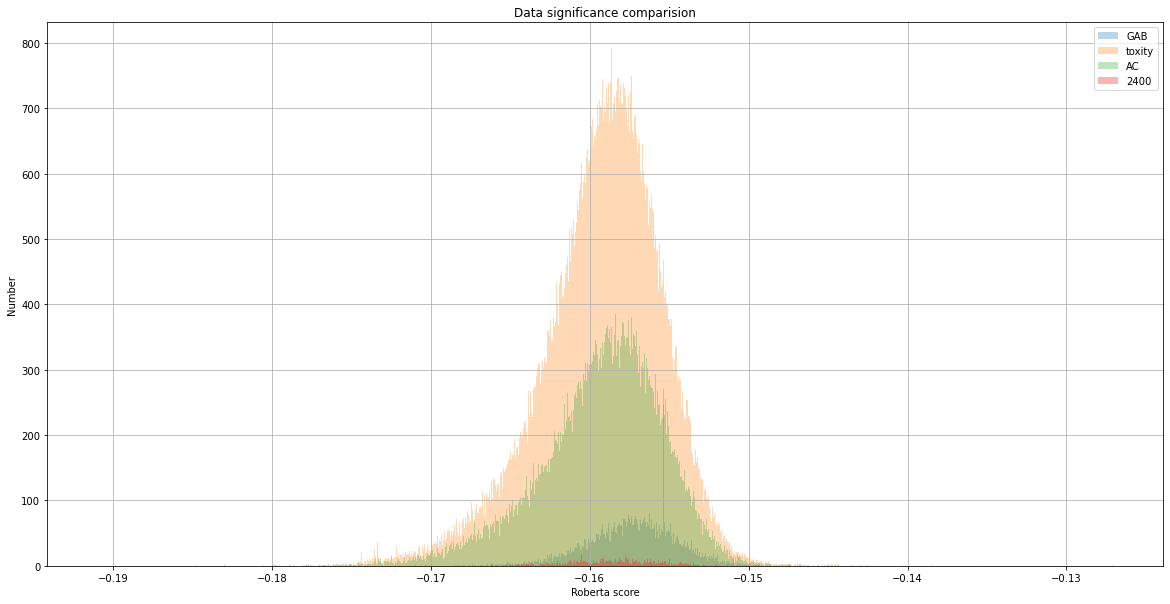

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.hist(Final_prediction_list_GAB, label= 'GAB', bins=1000,alpha = 0.3)
plt.hist(Final_prediction_list_toxity, label = 'toxity', bins = 1000,alpha = 0.3)
plt.hist(Final_prediction_list_AC,label = 'AC', bins = 1000,alpha = 0.3)
plt.hist(Final_prediction_list_2400, label = '2400', bins = 1000,color='r', alpha = 0.3)
plt.title('Data significance comparision')
plt.grid()
# plt.ylim(0,8)
plt.ylabel('Number')
plt.xlabel('Roberta score')
plt.legend()
plt.show()

## graph after normalization

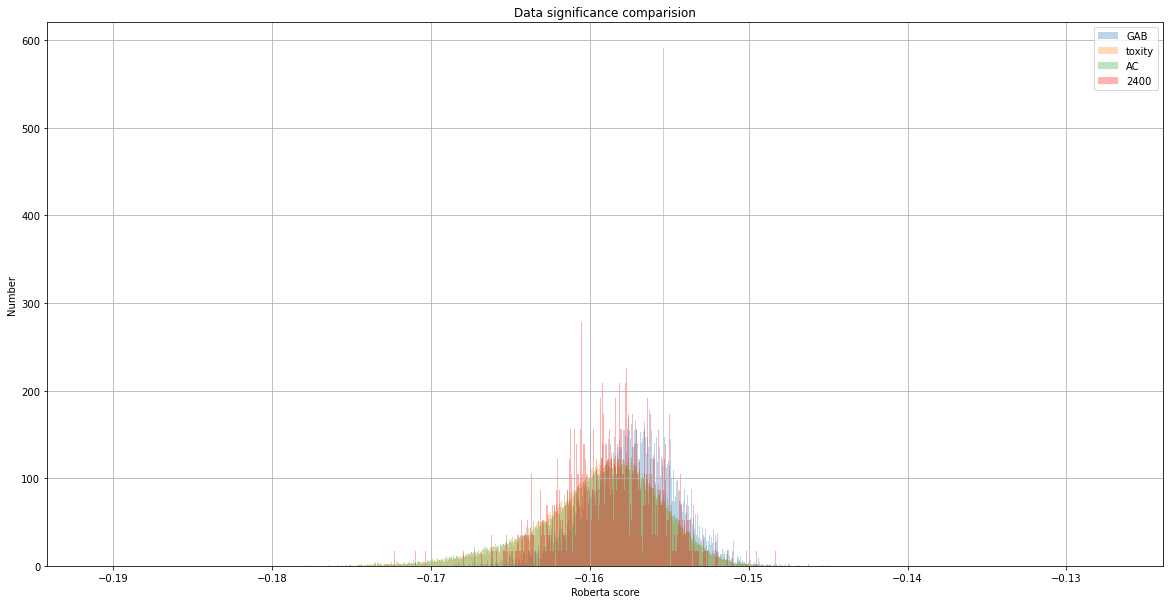

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.hist(Final_prediction_list_GAB, label= 'GAB', bins=1000,alpha = 0.3,density = True)
plt.hist(Final_prediction_list_toxity, label = 'toxity', bins = 1000,alpha = 0.3,density = True)
plt.hist(Final_prediction_list_AC,label = 'AC', bins = 1000,alpha = 0.3,density = True)
plt.hist(Final_prediction_list_2400, label = '2400', bins = 1000,color='r', alpha = 0.3,density = True)
plt.title('Data significance comparision')
plt.grid()
# plt.ylim(0,8)
plt.ylabel('Number')
plt.xlabel('Roberta score')
plt.legend()
plt.show()